In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import timedelta
import warnings
from scipy import stats
from sklearn import preprocessing, metrics, svm
from sklearn.linear_model import LogisticRegression
import os
warnings.filterwarnings('ignore')
pd.set_option('display.min_rows', 30)
pd.set_option('display.max_rows',150)
pd.set_option('display.width', 1000)

# Useful classes to have easier access to data features
class ColumnsInput:
    barcode = 'ddc_barcode'
    ipcode = 'ddc_ipcode'
    machine = 'ddc_mch_code'
    machine_side = 'ddc_mch_side'
    event = 'ddc_ev_subcode'
    time = 'ddc_ev_timestamp'
    
    
class ColumnsOutput:
    c_machine = 'c_machine' 
    event_delta_time = 'event_delta_time'
    day = 'y-m-day'
    hour = 'y-m-d-hour'
    month = 'month'
    status = 'status'

file_list = os.listdir('../Data/data_per_machine/2022/raw/')
print(file_list)
mach_name = [file.replace('.csv','') for file in file_list]
print(mach_name, len(mach_name))

['C403.csv', 'C103.csv', '1506.csv', 'C305.csv', 'C105.csv', 'C211.csv', '1306.csv', 'C603.csv', 'C210.csv', 'C605.csv', '1302.csv', 'C312.csv', '1501.csv', '1206.csv', 'C102.csv', 'C404.csv', '1402.csv', 'C307.csv', 'C207.csv', '1304.csv', '1406.csv', 'C511.csv', '1305.csv', 'C507.csv', '1301.csv', 'C608.csv', 'C612.csv', 'C209.csv', '1502.csv', '1403.csv', '1303.csv', 'C410.csv', 'C502.csv', 'C501.csv', '1507.csv', 'C407.csv', 'C412.csv', '1205.csv', 'C508.csv', '1404.csv', 'clustered', 'C303.csv', 'C111.csv', 'C610.csv', '1307.csv', 'C110.csv', 'C106.csv', 'C308.csv', 'C309.csv', 'C503.csv', '1407.csv', 'C202.csv', 'C509.csv', '1401.csv', 'C104.csv', 'C406.csv', '1203.csv', 'C601.csv', '1505.csv', 'C408.csv', 'C205.csv', 'C504.csv', 'C602.csv', 'C203.csv', 'C204.csv', 'C607.csv', 'C510.csv', 'C301.csv', 'C206.csv', 'C310.csv', 'C311.csv', 'C109.csv', '1201.csv', 'C411.csv', 'C512.csv', 'C101.csv', 'C405.csv', 'C401.csv', 'C505.csv', 'C201.csv', 'C409.csv', 'C302.csv', 'C606.csv', 'C

In [2]:
def general_plot(x_, y_, x_bounds = None, y_bounds = None, title = None, x_title = None, y_title = None):
    fig, ax = plt.subplots(figsize=(15, 4))

    plt.xticks(rotation=90)
    plt.grid(True)
    
    if title is not None:
        plt.title(title)
    
    if x_title is not None:    
        plt.xlabel(x_title)
        
    if y_title is not None:    
        plt.ylabel(y_title)
    
    if (x_bounds is not None):
        plt.xlim(x_bounds)
               
    if (y_bounds is not None):
        plt.ylim(y_bounds)
    ax.plot(x_,y_, 'bo')
    
    plt.show()

# Set the machine to analyse with the index


In [3]:
mach_index = 15

In [4]:
df = pd.read_csv('../Data/data_per_machine/2022/raw/' + file_list[mach_index])
df[ColumnsInput.time] = pd.to_datetime(df[ColumnsInput.time])
current_machine = mach_name[mach_index]
days = df[ColumnsOutput.day].unique()
df[ColumnsOutput.hour] = df[ColumnsInput.time].dt.strftime('%y-%m-%d-%H')
print(df.head())
print(df.info())


   Unnamed: 0  ddc_barcode  ddc_ipcode ddc_mch_code ddc_mch_side    ddc_ev_subcode    ddc_ev_timestamp  c_machine  month   y-m-day   y-m-d-hour
0          12   9439775944       27637         C404            L  CURING_OFF_START 2022-10-10 00:00:00       True     10  22-10-10  22-10-10-00
1        2666   9439776384       27637         C404            L    UN_VACUUM_STOP 2022-10-10 00:05:58       True     10  22-10-10  22-10-10-00
2        2824   9439775998       27637         C404            R    CURING_ON_STOP 2022-10-10 00:06:51       True     10  22-10-10  22-10-10-00
3        2825   9439775998       27637         C404            R  CURING_OFF_START 2022-10-10 00:06:51       True     10  22-10-10  22-10-10-00
4        2826   9439775997       27637         C404            L  CURING_OFF_START 2022-10-10 00:06:51       True     10  22-10-10  22-10-10-00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434735 entries, 0 to 434734
Data columns (total 11 columns):
 #   Column            No

In [5]:
working_time_per_day = df.groupby([ColumnsOutput.day])[ColumnsInput.time].agg(['min', 'max']).reset_index()
working_time_per_day['work_time'] = (working_time_per_day['max'] - working_time_per_day['min']).dt.total_seconds()
print(working_time_per_day.shape)
print(working_time_per_day.head())

working_time_per_day_per_arm = df.groupby([ColumnsOutput.day, ColumnsInput.machine_side])[ColumnsInput.time].agg(['min', 'max']).reset_index()
working_time_per_day_per_arm['work_time'] = (working_time_per_day_per_arm['max'] - working_time_per_day_per_arm['min']).dt.total_seconds()
print(working_time_per_day_per_arm.head())
working_time_per_day_per_right = working_time_per_day_per_arm[working_time_per_day_per_arm[ColumnsInput.machine_side] == 'R'].reset_index().drop('index', axis = 1)
working_time_per_day_per_left = working_time_per_day_per_arm[working_time_per_day_per_arm[ColumnsInput.machine_side] == 'L'].reset_index().drop('index', axis = 1)
working_time_per_day_per_right.shape


(54, 4)
    y-m-day                 min                 max  work_time
0  22-10-10 2022-10-10 00:00:00 2022-10-10 23:53:19    85999.0
1  22-10-11 2022-10-11 00:00:00 2022-10-11 23:53:27    86007.0
2  22-10-12 2022-10-12 00:00:21 2022-10-12 23:50:01    85780.0
3  22-10-13 2022-10-13 00:04:13 2022-10-13 23:56:27    85934.0
4  22-10-14 2022-10-14 00:06:25 2022-10-14 20:02:09    71744.0
    y-m-day ddc_mch_side                 min                 max  work_time
0  22-10-10            L 2022-10-10 00:00:00 2022-10-10 23:53:19    85999.0
1  22-10-10            R 2022-10-10 00:06:51 2022-10-10 23:53:19    85588.0
2  22-10-11            L 2022-10-11 00:00:00 2022-10-11 23:53:27    86007.0
3  22-10-11            R 2022-10-11 00:07:49 2022-10-11 23:53:27    85538.0
4  22-10-12            L 2022-10-12 00:00:21 2022-10-12 23:50:01    85780.0


(54, 5)

In [6]:
mach_tyre_per_day = df.groupby([ColumnsOutput.day])[ColumnsInput.barcode].nunique().dropna().reset_index()
print(mach_tyre_per_day.shape)
mach_tyre_per_day_per_arm = df.groupby([ColumnsOutput.day, ColumnsInput.machine_side])[ColumnsInput.barcode].nunique().reset_index()
print(mach_tyre_per_day_per_arm.shape)
mach_tyre_per_day_per_left = mach_tyre_per_day_per_arm[mach_tyre_per_day_per_arm[ColumnsInput.machine_side] == 'L'].reset_index().drop('index', axis = 1)
mach_tyre_per_day_per_right = mach_tyre_per_day_per_arm[mach_tyre_per_day_per_arm[ColumnsInput.machine_side] == 'R'].reset_index().drop('index', axis = 1)



(54, 2)
(106, 3)


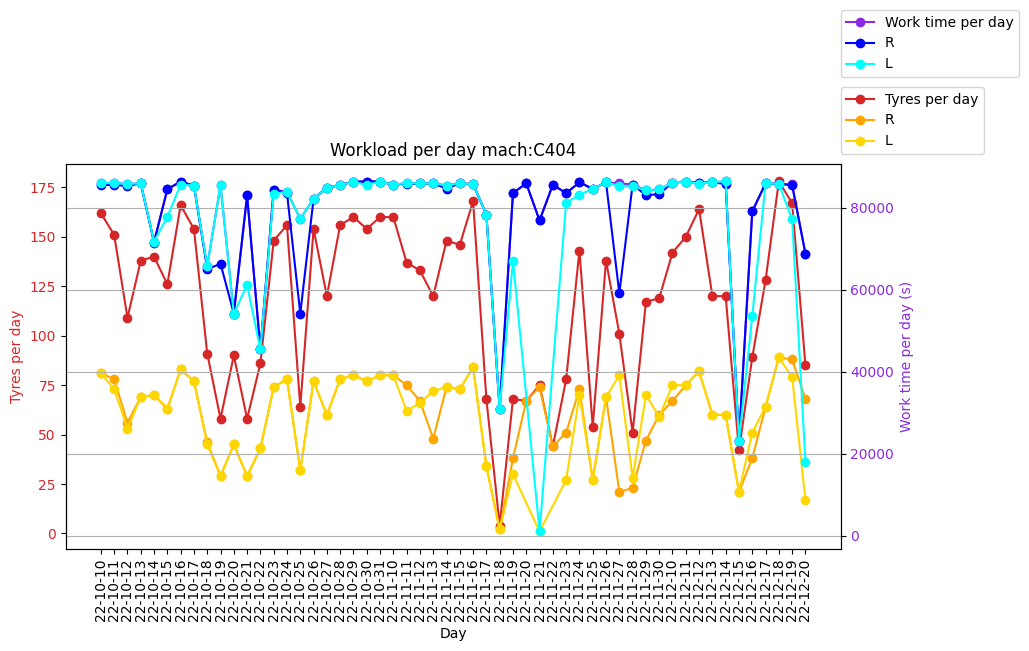

In [7]:
x = mach_tyre_per_day[ColumnsOutput.day]
figure, ax_left = plt.subplots(figsize=(10, 5)) 

color = 'tab:red'
ax_left.set_xticklabels(mach_tyre_per_day[ColumnsOutput.day], rotation=90)
ax_left.set_ylabel('Tyres per day', color=color)
ax_left.set_xlabel('Day')
ax_left.plot(x, mach_tyre_per_day[ColumnsInput.barcode], '-bo', label = 'Tyres per day', color=color)
ax_left.plot(mach_tyre_per_day_per_right[ColumnsOutput.day], mach_tyre_per_day_per_right[ColumnsInput.barcode], '-bo', label = 'R', color='orange')
ax_left.plot(mach_tyre_per_day_per_left[ColumnsOutput.day], mach_tyre_per_day_per_left[ColumnsInput.barcode], '-bo', label = 'L', color='gold')
ax_left.tick_params(axis='y', labelcolor=color)
ax_left.legend(bbox_to_anchor=(1, 1.2), loc=2, borderaxespad=0.)

color = 'blueviolet'
ax_right = ax_left.twinx()
ax_right.set_ylabel('Work time per day (s)', color=color)
ax_right.plot(x, working_time_per_day['work_time'], '-ro', label = 'Work time per day', color=color)
ax_right.plot(working_time_per_day_per_right[ColumnsOutput.day], working_time_per_day_per_right['work_time'], '-ro', label = 'R', color='blue')
ax_right.plot(working_time_per_day_per_left[ColumnsOutput.day], working_time_per_day_per_left['work_time'], '-ro', label = 'L', color='cyan')
ax_right.tick_params(axis='y', labelcolor=color)
ax_right.legend(bbox_to_anchor=(1, 1.4), loc=2, borderaxespad=0.)
plt.title(f'Workload per day mach:{current_machine}')
plt.grid(axis='x')
plt.grid(axis='y')
plt.grid(True)
plt.show()


## Dividing the plots

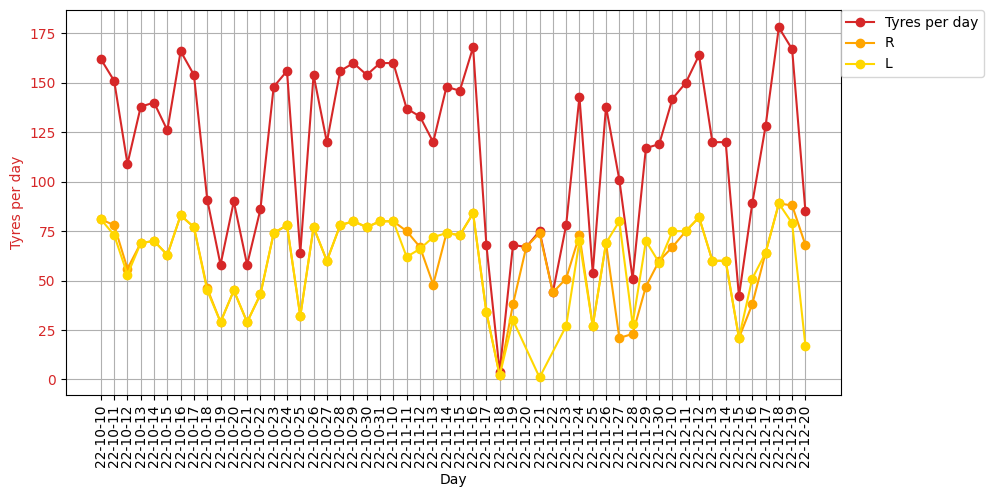

In [8]:
x = mach_tyre_per_day[ColumnsOutput.day]
figure, ax_left = plt.subplots(figsize=(10, 5)) 

color = 'tab:red'
ax_left.set_xticklabels(mach_tyre_per_day[ColumnsOutput.day], rotation=90)
ax_left.set_ylabel('Tyres per day', color=color)
ax_left.set_xlabel('Day')
ax_left.plot(x, mach_tyre_per_day[ColumnsInput.barcode], '-bo', label = 'Tyres per day', color=color)
ax_left.plot(mach_tyre_per_day_per_right[ColumnsOutput.day], mach_tyre_per_day_per_right[ColumnsInput.barcode], '-bo', label = 'R', color='orange')
ax_left.plot(mach_tyre_per_day_per_left[ColumnsOutput.day], mach_tyre_per_day_per_left[ColumnsInput.barcode], '-bo', label = 'L', color='gold')
ax_left.tick_params(axis='y', labelcolor=color)
ax_left.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.grid(axis='x')
plt.grid(axis='y')
plt.grid(True)
plt.show()

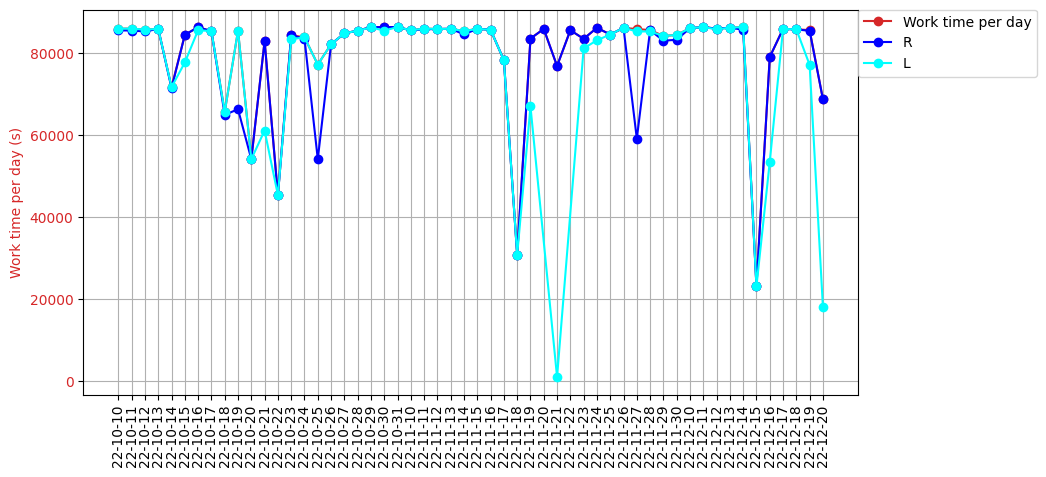

In [9]:
x = working_time_per_day[ColumnsOutput.day]
figure, ax_right = plt.subplots(figsize=(10, 5)) 

color = 'tab:red'
ax_right.set_ylabel('Work time per day (s)', color=color)
ax_right.set_xticklabels(mach_tyre_per_day[ColumnsOutput.day], rotation=90)
ax_right.plot(x, working_time_per_day['work_time'], '-ro', label = 'Work time per day', color=color)
ax_right.plot(working_time_per_day_per_right[ColumnsOutput.day], working_time_per_day_per_right['work_time'], '-ro', label = 'R', color='blue')
ax_right.plot(working_time_per_day_per_left[ColumnsOutput.day], working_time_per_day_per_left['work_time'], '-ro', label = 'L', color='cyan')
ax_right.tick_params(axis='y', labelcolor=color)
ax_right.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.grid(axis='x')
plt.grid(axis='y')
plt.grid(True)
plt.show()

In [10]:
# mean_n_tyre_per_day = mach_tyre_per_day[ColumnsInput.barcode].mean()
# for i in range(len(mach_tyre_per_day)):
#     if mach_tyre_per_day[ColumnsInput.barcode][i] <=  mean_n_tyre_per_day:
#         print('Machine '+str(current_machine)+ " in day " +mach_tyre_per_day[ColumnsOutput.day][i] +' is underperforming')
#         df.drop(df[df[ColumnsOutput.day] == mach_tyre_per_day[ColumnsOutput.day][i]].index, inplace = True)

In [11]:
label_cycle_status = df.sort_values(ColumnsInput.time).groupby([ColumnsOutput.day, ColumnsInput.machine_side,ColumnsInput.barcode], dropna=False)[ColumnsInput.event].agg(['first', 'last']).reset_index()
label_cycle_status[ColumnsOutput.status] = False
print(label_cycle_status.columns)
starting_event = ["LO_LOADER_IN_PRESS", "LO_LOADER_IN_PRESS_START"]
ending_event = ["UN_UNLOADER_OUT", "UN_FORK_OUT", "UN_UNLOADER_OUT_STOP", "UN_FORK_OUT_STOP"]

label_cycle_status[ColumnsOutput.status] = label_cycle_status.apply(lambda x: 'CYCLE_COMPLETED' if x['last'] in ending_event else 'CYCLE_ABORTED' if x['first'] in starting_event else 'CYCLE_NOT_STARTED', axis=1)
label_cycle_status.value_counts(ColumnsOutput.status)
label_cycle_status.shape
label_cycle_status_ = label_cycle_status.copy()
label_for_check_time_loss = label_cycle_status_

Index(['y-m-day', 'ddc_mch_side', 'ddc_barcode', 'first', 'last', 'status'], dtype='object')


<Axes: xlabel='status'>

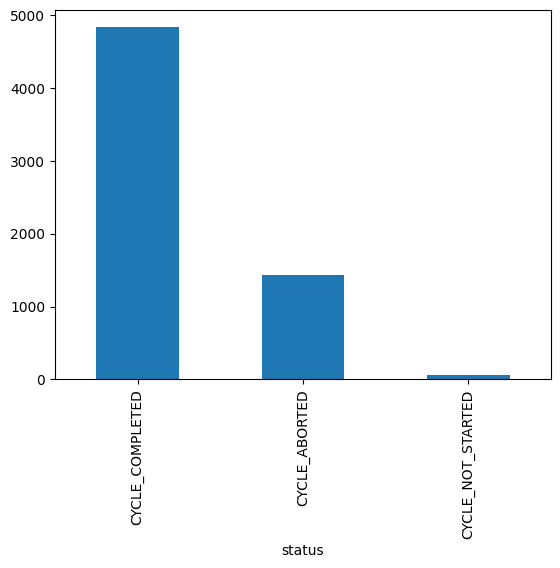

In [12]:
label_cycle_status_[ColumnsOutput.status].value_counts().plot(kind='bar')    

<Axes: xlabel='status'>

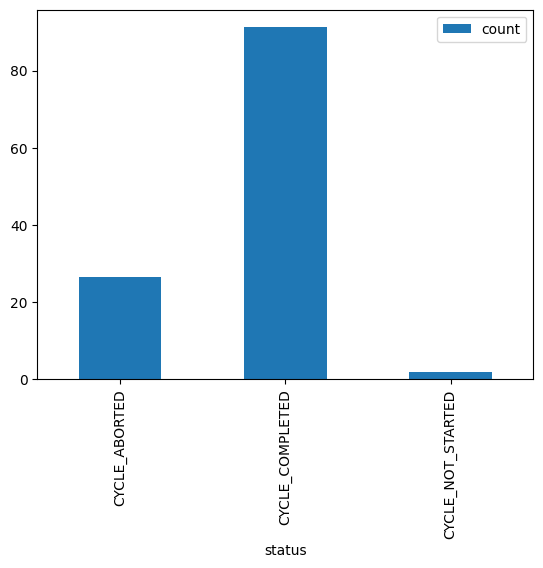

In [13]:
cycle_statuses_per_day = label_cycle_status_.groupby([ColumnsOutput.day])[ColumnsOutput.status].value_counts().reset_index()
cycle_statuses_per_day_mean = cycle_statuses_per_day.groupby([ColumnsOutput.status])['count'].mean().reset_index()
cycle_statuses_per_day_mean.plot(kind='bar', x=ColumnsOutput.status, y='count')

In [14]:
cycle_statuses_per_day = label_cycle_status.groupby([ColumnsOutput.day], dropna=False)[ColumnsOutput.status].value_counts().unstack(fill_value=0).reset_index()

status_names = ['CYCLE_COMPLETED','CYCLE_ABORTED', 'CYCLE_NOT_STARTED']

for status in status_names:
    if status not in cycle_statuses_per_day.columns:
        print(f'{status} not in columns')
        cycle_statuses_per_day[status] = 0
print(len(cycle_statuses_per_day))
print(cycle_statuses_per_day.head())
statuses_per_day = []
statuses_per_day.append(cycle_statuses_per_day.drop(['CYCLE_ABORTED', 'CYCLE_NOT_STARTED'], axis=1))
statuses_per_day.append(cycle_statuses_per_day.drop(['CYCLE_COMPLETED', 'CYCLE_NOT_STARTED'], axis=1))
statuses_per_day.append(cycle_statuses_per_day.drop(['CYCLE_COMPLETED', 'CYCLE_ABORTED'], axis=1))
for i in statuses_per_day:
    print(i.shape)
    print(i.columns)
    i.rename(columns={'CYCLE_COMPLETED':'count', 'CYCLE_ABORTED':'count', 'CYCLE_NOT_STARTED':'count'}, inplace=True)
    print(i.columns)
    print('\n')

54
status   y-m-day  CYCLE_ABORTED  CYCLE_COMPLETED  CYCLE_NOT_STARTED
0       22-10-10             31              131                  0
1       22-10-11             24              125                  2
2       22-10-12             27               81                  1
3       22-10-13             22              116                  0
4       22-10-14             20              118                  2
(54, 2)
Index(['y-m-day', 'CYCLE_COMPLETED'], dtype='object', name='status')
Index(['y-m-day', 'count'], dtype='object', name='status')


(54, 2)
Index(['y-m-day', 'CYCLE_ABORTED'], dtype='object', name='status')
Index(['y-m-day', 'count'], dtype='object', name='status')


(54, 2)
Index(['y-m-day', 'CYCLE_NOT_STARTED'], dtype='object', name='status')
Index(['y-m-day', 'count'], dtype='object', name='status')




3


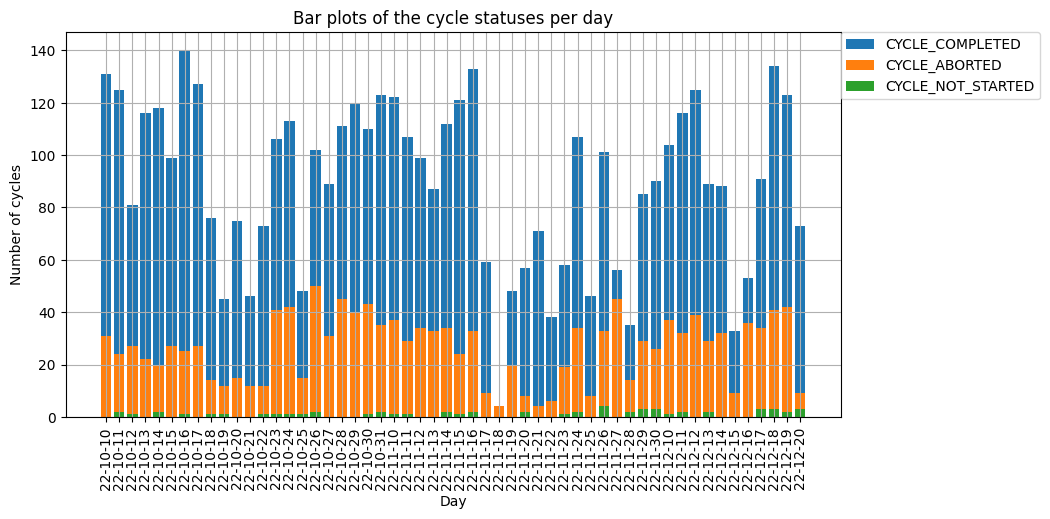

In [15]:
figure, ax = plt.subplots(figsize=(10, 5))
ax.set_xticklabels(statuses_per_day[0][ColumnsOutput.day], rotation=90)
print(len(statuses_per_day))
for i in range(len(statuses_per_day)):
    ax.bar(statuses_per_day[i][ColumnsOutput.day], statuses_per_day[i]['count'], label = status_names[i])
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.title('Bar plots of the cycle statuses per day')
plt.xlabel('Day')
plt.ylabel('Number of cycles')
plt.grid(True)
plt.show()


### Checking right and left sides as well

In [16]:
# label_cycle_status_right = label_cycle_status[label_cycle_status[ColumnsInput.machine_side] == 'R']
# label_cycle_status_left = label_cycle_status[label_cycle_status[ColumnsInput.machine_side] == 'L']
# cycle_statuses_per_day_left = label_cycle_status_left.groupby([ColumnsInput.machine_side,ColumnsOutput.day], dropna=False)[ColumnsOutput.status].value_counts().reset_index()

# statuses_per_day_left = []
# for status in cycle_statuses_per_day_left[ColumnsOutput.status].unique():
#     statuses_per_day_left.append(cycle_statuses_per_day_left[cycle_statuses_per_day_left[ColumnsOutput.status] == status].reset_index().drop('index', axis = 1))
# for i in statuses_per_day_left:
#     print(i.shape)
#     print('\n')
# cycle_statuses_per_day_right = label_cycle_status_right.groupby([ColumnsInput.machine_side,ColumnsOutput.day], dropna=False)[ColumnsOutput.status].value_counts().reset_index()

# statuses_per_day_right = []
# for status in cycle_statuses_per_day_right[ColumnsOutput.status].unique():
#     statuses_per_day_right.append(cycle_statuses_per_day_right[cycle_statuses_per_day_right[ColumnsOutput.status] == status].reset_index().drop('index', axis = 1))
# for i in statuses_per_day_right:
#     print(i.shape)
#     print('\n')


# cycle_statuses_per_day_ = label_cycle_status.groupby([ColumnsOutput.day, ColumnsInput.machine_side], dropna=False)[ColumnsOutput.status].value_counts().unstack(fill_value=0).reset_index()
# cycle_statuses_per_day_right = cycle_statuses_per_day_[cycle_statuses_per_day_[ColumnsInput.machine_side] == 'R'].reset_index()
# cycle_statuses_per_day_left = cycle_statuses_per_day_[cycle_statuses_per_day_[ColumnsInput.machine_side] == 'L'].reset_index()
# for status in status_names:
#     if status not in cycle_statuses_per_day_left.columns:
#         print(f'{status} not in columns')
#         cycle_statuses_per_day_left[status] = 0
#     if status not in cycle_statuses_per_day_right.columns:
#         print(f'{status} not in columns')
#         cycle_statuses_per_day_right[status] = 0
# print(cycle_statuses_per_day_right)




In [17]:
cycle_statuses_per_day_ = label_cycle_status.groupby([ColumnsOutput.day, ColumnsInput.machine_side], dropna=False)[ColumnsOutput.status].value_counts().unstack(fill_value=0).reset_index()
cycle_statuses_per_day_left = cycle_statuses_per_day_[cycle_statuses_per_day_[ColumnsInput.machine_side] == 'L'].reset_index()
cycle_statuses_per_day_right = cycle_statuses_per_day_[cycle_statuses_per_day_[ColumnsInput.machine_side] == 'R'].reset_index()

status_names = ['CYCLE_COMPLETED','CYCLE_ABORTED', 'CYCLE_NOT_STARTED']

for status in status_names:
    if status not in cycle_statuses_per_day_left.columns:
        print(f'{status} not in columns')
        cycle_statuses_per_day_left[status] = 0
    if status not in cycle_statuses_per_day_right.columns:
        print(f'{status} not in columns')
        cycle_statuses_per_day_right[status] = 0
statuses_per_day_left = []
statuses_per_day_left.append(cycle_statuses_per_day_left.drop(['CYCLE_ABORTED', 'CYCLE_NOT_STARTED'], axis=1))
statuses_per_day_left.append(cycle_statuses_per_day_left.drop(['CYCLE_COMPLETED', 'CYCLE_NOT_STARTED'], axis=1))
statuses_per_day_left.append(cycle_statuses_per_day_left.drop(['CYCLE_COMPLETED', 'CYCLE_ABORTED'], axis=1))
for i in statuses_per_day_left:
    print(i.shape)
    print(i.columns)
    i.rename(columns={'CYCLE_COMPLETED':'count', 'CYCLE_ABORTED':'count', 'CYCLE_NOT_STARTED':'count'}, inplace=True)
    print(i.columns)
    print('\n')
statuses_per_day_right = []    
statuses_per_day_right.append(cycle_statuses_per_day_right.drop(['CYCLE_ABORTED', 'CYCLE_NOT_STARTED'], axis=1))
statuses_per_day_right.append(cycle_statuses_per_day_right.drop(['CYCLE_COMPLETED', 'CYCLE_NOT_STARTED'], axis=1))
statuses_per_day_right.append(cycle_statuses_per_day_right.drop(['CYCLE_COMPLETED', 'CYCLE_ABORTED'], axis=1))
for i in statuses_per_day_right:
    print(i.shape)
    print(i.columns)
    i.rename(columns={'CYCLE_COMPLETED':'count', 'CYCLE_ABORTED':'count', 'CYCLE_NOT_STARTED':'count'}, inplace=True)
    print(i.columns)
    print('\n')

(52, 4)
Index(['index', 'y-m-day', 'ddc_mch_side', 'CYCLE_COMPLETED'], dtype='object', name='status')
Index(['index', 'y-m-day', 'ddc_mch_side', 'count'], dtype='object', name='status')


(52, 4)
Index(['index', 'y-m-day', 'ddc_mch_side', 'CYCLE_ABORTED'], dtype='object', name='status')
Index(['index', 'y-m-day', 'ddc_mch_side', 'count'], dtype='object', name='status')


(52, 4)
Index(['index', 'y-m-day', 'ddc_mch_side', 'CYCLE_NOT_STARTED'], dtype='object', name='status')
Index(['index', 'y-m-day', 'ddc_mch_side', 'count'], dtype='object', name='status')


(54, 4)
Index(['index', 'y-m-day', 'ddc_mch_side', 'CYCLE_COMPLETED'], dtype='object', name='status')
Index(['index', 'y-m-day', 'ddc_mch_side', 'count'], dtype='object', name='status')


(54, 4)
Index(['index', 'y-m-day', 'ddc_mch_side', 'CYCLE_ABORTED'], dtype='object', name='status')
Index(['index', 'y-m-day', 'ddc_mch_side', 'count'], dtype='object', name='status')


(54, 4)
Index(['index', 'y-m-day', 'ddc_mch_side', 'CYCLE_NOT_

3


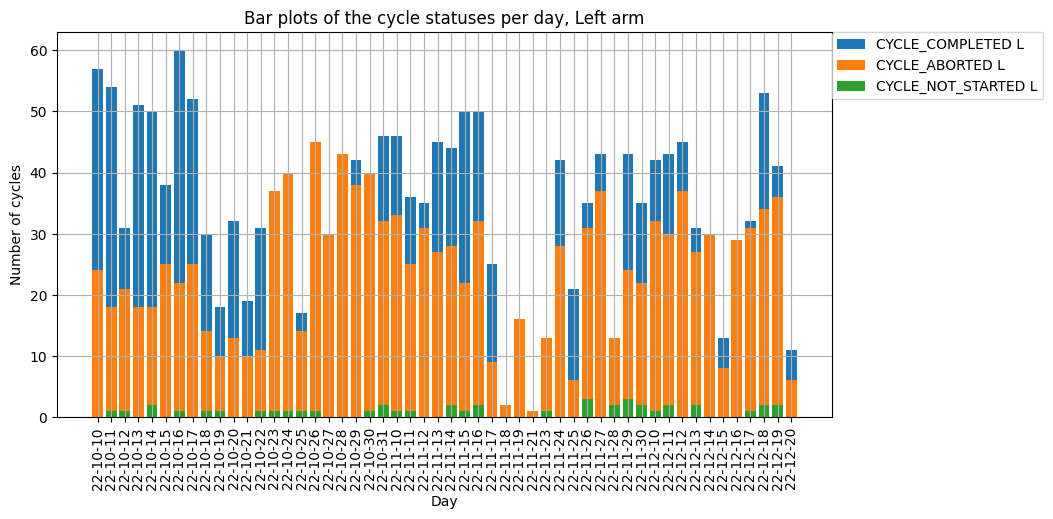

In [18]:
figure, ax = plt.subplots(figsize=(10, 5))
ax.set_xticklabels(statuses_per_day_left[0][ColumnsOutput.day], rotation=90)
print(len(statuses_per_day_left))
plt.bar(statuses_per_day_left[0][ColumnsOutput.day], statuses_per_day_left[0]['count'], label = status_names[0] +' L')
plt.bar(statuses_per_day_left[1][ColumnsOutput.day], statuses_per_day_left[1]['count'], label = status_names[1] + ' L')
plt.bar(statuses_per_day_left[2][ColumnsOutput.day], statuses_per_day_left[2]['count'], label = status_names[2] + ' L')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.title('Bar plots of the cycle statuses per day, Left arm')
plt.xlabel('Day')
plt.ylabel('Number of cycles')
plt.grid(True)

54


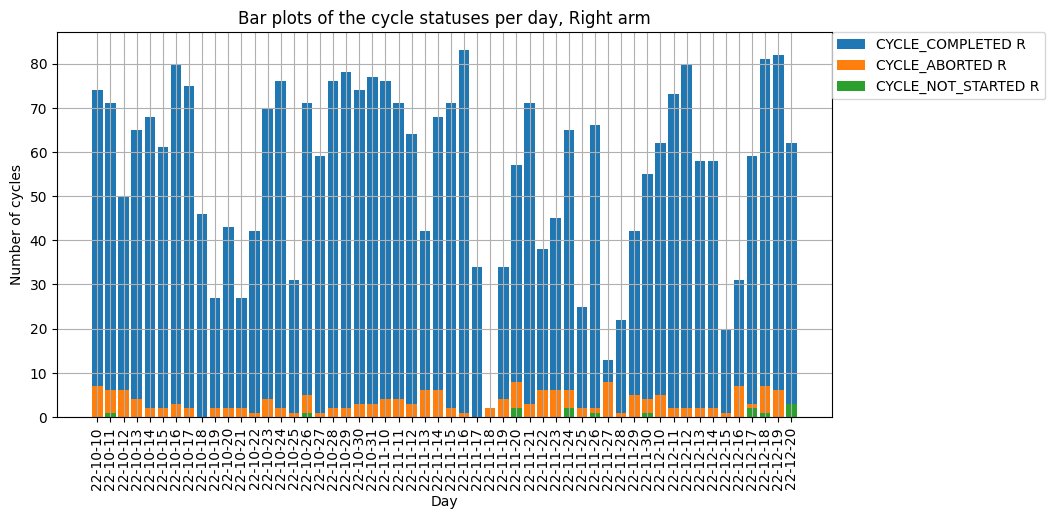

In [19]:
figure, ax = plt.subplots(figsize=(10, 5))
ax.set_xticklabels(statuses_per_day_right[0][ColumnsOutput.day], rotation=90)
print(len(statuses_per_day[2]))
plt.bar(statuses_per_day_right[0][ColumnsOutput.day], statuses_per_day_right[0]['count'], label = status_names[0] + ' R')
plt.bar(statuses_per_day_right[1][ColumnsOutput.day], statuses_per_day_right[1]['count'], label = status_names[1] + ' R')
plt.bar(statuses_per_day_right[2][ColumnsOutput.day], statuses_per_day_right[2]['count'], label = status_names[2] + ' R')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.title('Bar plots of the cycle statuses per day, Right arm')
plt.xlabel('Day')
plt.ylabel('Number of cycles')
plt.grid(True)

In [20]:
# figure, ax = plt.subplots(figsize=(10, 5))
# print(len(statuses_per_day[0]))
# #ax.set_xticklabels(statuses_per_day[0][ColumnsOutput.day], rotation=90)
# print(len(statuses_per_day_right[2]), len(statuses_per_day_left[2]))

# for i in range(len(statuses_per_day)-1):
#     x = np.arange(len(days))
#     x1 = [i + 0.4 for i in x]
#     ax.bar(x, statuses_per_day_right[i]['count'], width = 0.4, label = str(statuses_per_day_right[i][ColumnsOutput.status].unique()))
#     ax.bar(x1, statuses_per_day_left[i]['count'], width = 0.4, label = str(statuses_per_day_left[i][ColumnsOutput.status].unique()))

# plt.grid(True)
# plt.show()

Index(['y-m-day', 'ddc_ev_timestamp', 'ddc_mch_side', 'ddc_barcode', 'first', 'last', 'status'], dtype='object')
    y-m-day    ddc_ev_timestamp ddc_mch_side  ddc_barcode             first                  last             status
0  22-10-10 2022-10-10 00:00:00            L   9439775944  CURING_OFF_START      CURING_OFF_START  CYCLE_NOT_STARTED
1  22-10-10 2022-10-10 00:05:58            L   9439776384    UN_VACUUM_STOP        UN_VACUUM_STOP  CYCLE_NOT_STARTED
2  22-10-10 2022-10-10 00:06:51            L   9439775997  CURING_OFF_START        CURING_ON_STOP  CYCLE_NOT_STARTED
3  22-10-10 2022-10-10 00:06:51            R   9439775998    CURING_ON_STOP      CURING_OFF_START  CYCLE_NOT_STARTED
4  22-10-10 2022-10-10 00:06:53            L   9439775997   CURING_OFF_STOP  OP_SQUEEZE_OFF_START  CYCLE_NOT_STARTED


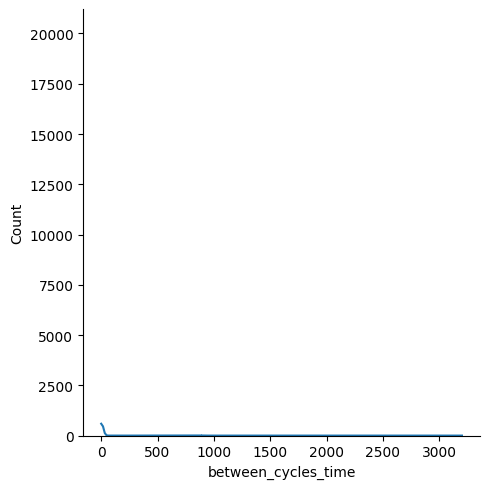

In [21]:
label_cycle_status_for_time = df.sort_values(ColumnsInput.time).groupby([ColumnsOutput.day, ColumnsInput.time, ColumnsInput.machine_side,ColumnsInput.barcode], dropna=False)[ColumnsInput.event].agg(['first', 'last']).reset_index()
label_cycle_status_for_time[ColumnsOutput.status] = False
print(label_cycle_status_for_time.columns)
starting_event = ["LO_LOADER_IN_PRESS", "LO_LOADER_IN_PRESS_START"]
ending_event = ["UN_UNLOADER_OUT", "UN_FORK_OUT", "UN_UNLOADER_OUT_STOP", "UN_FORK_OUT_STOP"]

label_cycle_status_for_time[ColumnsOutput.status] = label_cycle_status_for_time.apply(lambda x: 'CYCLE_COMPLETED' if x['last'] in ending_event else 'CYCLE_ABORTED' if x['first'] in starting_event else 'CYCLE_NOT_STARTED', axis=1)
label_cycle_status_for_time.value_counts(ColumnsOutput.status)
print(label_cycle_status_for_time.head())
plt.show()

label_cycle_status_for_time_left = label_cycle_status_for_time[label_cycle_status_for_time[ColumnsInput.machine_side] == 'L']
label_cycle_status_for_time_right = label_cycle_status_for_time[label_cycle_status_for_time[ColumnsInput.machine_side] == 'R']

label_cycle_status_for_time_left['between_cycles_time'] = label_cycle_status_for_time_left[ColumnsInput.time].diff().dt.total_seconds()
label_cycle_status_for_time_right['between_cycles_time'] = label_cycle_status_for_time_right[ColumnsInput.time].diff().dt.total_seconds()

label_cycle_status_for_time_left['between_cycles_time'] = label_cycle_status_for_time_left['between_cycles_time'].fillna(0)
label_cycle_status_for_time_right['between_cycles_time'] = label_cycle_status_for_time_right['between_cycles_time'].fillna(0)

z = np.abs(stats.zscore(label_cycle_status_for_time_right['between_cycles_time']))
label_cycle_status_for_time_right = label_cycle_status_for_time_right[(z < 1)]

z = np.abs(stats.zscore(label_cycle_status_for_time_left['between_cycles_time']))
label_cycle_status_for_time_left = label_cycle_status_for_time_left[(z < 1)]

sns.displot(label_cycle_status_for_time_right['between_cycles_time'], kde=True)
plt.show()

# label_cycle_status_for_time_right_stats = label_cycle_status_for_time_right.groupby([ColumnsOutput.status])['between_cycles_time'].agg(['mean', 'median', 'std', 'min', 'max']).reset_index()
# label_cycle_status_for_time_left_stats = label_cycle_status_for_time_left.groupby([ColumnsOutput.status])['between_cycles_time'].agg(['mean', 'median', 'std', 'min', 'max']).reset_index()

# print(label_cycle_status_for_time_right_stats)
# label_cycle_status_for_time_left_stats.plot(kind='bar', x=ColumnsOutput.status, y='mean')
# print(label_cycle_status_for_time_left_stats)
# label_cycle_status_for_time_right_stats.plot(kind='bar', x=ColumnsOutput.status, y='mean')



## Getting all previous indices per day fro the machines

In [22]:

len(days)



54

In [23]:
# variables = [mach_tyre_per_day, mach_tyre_per_day_per_left, mach_tyre_per_day_per_right ,working_time_per_day, working_time_per_day_per_left, 
#              working_time_per_day_per_right, statuses_per_day_left[0], statuses_per_day_left[1], statuses_per_day_left[2], 
#              statuses_per_day_right[0], statuses_per_day_right[1], statuses_per_day_right[2], statuses_per_day[0], statuses_per_day[1], 
#              statuses_per_day[2]] # TODO issue on index
tyre_per_day = mach_tyre_per_day[ColumnsInput.barcode]
tyre_per_day_left = mach_tyre_per_day_per_left[ColumnsInput.barcode]


tyre_per_day_right = mach_tyre_per_day_per_right[ColumnsInput.barcode]
work_time_per_day = working_time_per_day['work_time']
work_time_per_day_left = working_time_per_day_per_left['work_time']
work_time_per_day_right = working_time_per_day_per_right['work_time']
status_per_day_left_1 = cycle_statuses_per_day_left['CYCLE_COMPLETED']
status_per_day_left_2 =cycle_statuses_per_day_left['CYCLE_ABORTED']
status_per_day_left_3 = cycle_statuses_per_day_left['CYCLE_NOT_STARTED']
status_per_day_right_1 = cycle_statuses_per_day_right['CYCLE_COMPLETED']
status_per_day_right_2 = cycle_statuses_per_day_right['CYCLE_ABORTED']
status_per_day_right_3 = cycle_statuses_per_day_right['CYCLE_NOT_STARTED']
status_per_day_1 = statuses_per_day[0]['count']
status_per_day_2 = statuses_per_day[1]['count']
status_per_day_3 = statuses_per_day[2]['count']

# colums_name = ['day', 'tyre_per_day', 'tyre_per_day_left', 'tyre_per_day_right', 'work_time_per_day', 'work_time_per_day_left', 'work_time_per_day_right','completed_jobs_left', 'aborted_jobs_left', 'not_started_jobs_left', 'completed_jobs_right', 'aborted_jobs_right', 'not_started_jobs_right', 'completed_jobs', 'aborted_jobs', 'not_started_jobs']

mach_processed_df = pd.DataFrame()
mach_processed_df['day'] = days
mach_processed_df['tyre_per_day'] = tyre_per_day
mach_processed_df['tyre_per_day_left'] = tyre_per_day_left
mach_processed_df['tyre_per_day_right'] = tyre_per_day_right
mach_processed_df['work_time_per_day'] = work_time_per_day
mach_processed_df['work_time_per_day_left'] = work_time_per_day_left
mach_processed_df['work_time_per_day_right'] = work_time_per_day_right
mach_processed_df['completed_jobs_left'] = status_per_day_left_1
mach_processed_df['aborted_jobs_left'] = status_per_day_left_2
mach_processed_df['not_started_jobs_left'] = status_per_day_left_3
mach_processed_df['completed_jobs_right'] = status_per_day_right_1
mach_processed_df['aborted_jobs_right'] = status_per_day_right_2
mach_processed_df['not_started_jobs_right'] = status_per_day_right_3
mach_processed_df['completed_jobs'] = status_per_day_1
mach_processed_df['aborted_jobs'] = status_per_day_2
mach_processed_df['not_started_jobs'] = status_per_day_3

mach_processed_df.sort_values(by=['day'], inplace = True)
#mach_processed_df.fillna(0, inplace = True)
mach_processed_df


,day,tyre_per_day,tyre_per_day_left,tyre_per_day_right,work_time_per_day,work_time_per_day_left,work_time_per_day_right,completed_jobs_left,aborted_jobs_left,not_started_jobs_left,completed_jobs_right,aborted_jobs_right,not_started_jobs_right,completed_jobs,aborted_jobs,not_started_jobs
0,22-10-10,162,81.0,81,85999.0,85999.0,85588.0,57.0,24.0,0.0,74,7,0,131,31,0
1,22-10-11,151,73.0,78,86007.0,86007.0,85538.0,54.0,18.0,1.0,71,6,1,125,24,2
2,22-10-12,109,53.0,56,85780.0,85780.0,85318.0,31.0,21.0,1.0,50,6,0,81,27,1
3,22-10-13,138,69.0,69,85934.0,85934.0,85934.0,51.0,18.0,0.0,65,4,0,116,22,0
4,22-10-14,140,70.0,70,71744.0,71738.0,71479.0,50.0,18.0,2.0,68,2,0,118,20,2
5,22-10-15,126,63.0,63,84507.0,77754.0,84507.0,38.0,25.0,0.0,61,2,0,99,27,0
6,22-10-16,166,83.0,83,86364.0,85652.0,86364.0,60.0,22.0,1.0,80,3,0,140,25,1
7,22-10-17,154,77.0,77,85381.0,85381.0,85381.0,52.0,25.0,0.0,75,2,0,127,27,0
8,22-10-18,91,45.0,46,65695.0,65689.0,64981.0,30.0,14.0,1.0,46,0,0,76,14,1
9,22-10-19,58,29.0,29,85495.0,85494.0,66336.0,18.0,10.0,1.0,27,2,0,45,12,1


<Axes: >

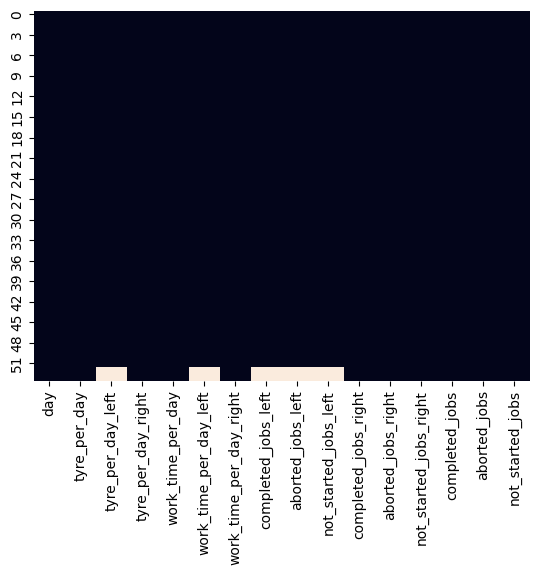

In [24]:
sns.heatmap(mach_processed_df.isna(), cbar=False)

In [25]:
mach_processed_df = mach_processed_df.fillna(0)

### Correlation between the tyres produced and the completed cycles

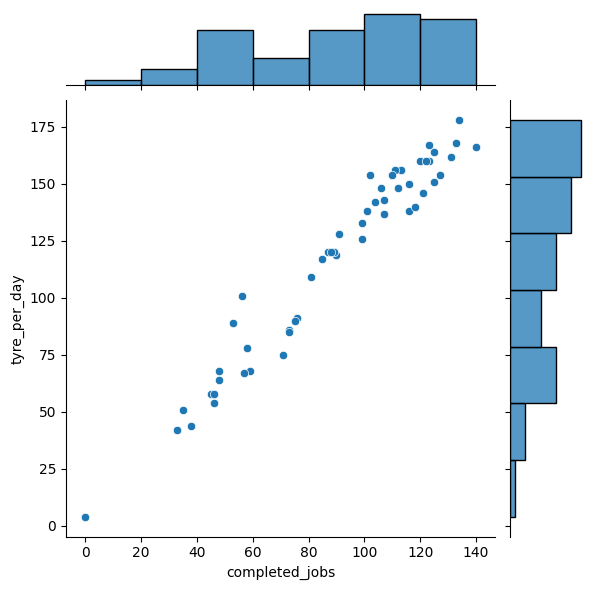

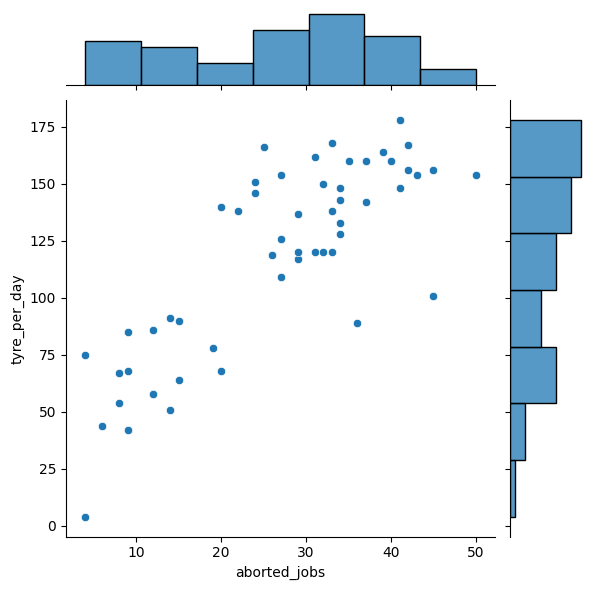

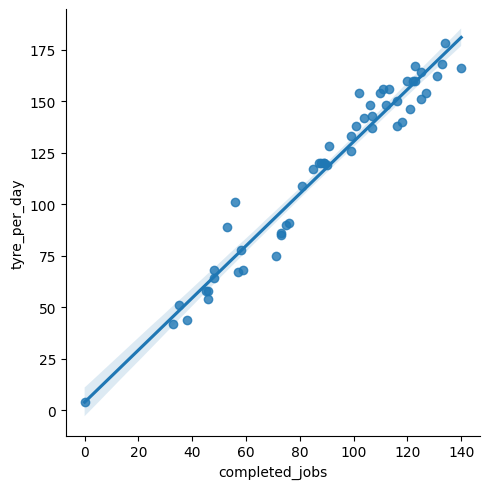

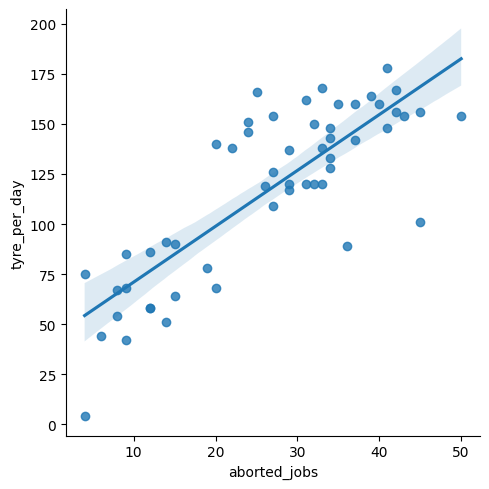

In [26]:
sns.jointplot(x='completed_jobs',y='tyre_per_day',data=mach_processed_df,kind='scatter')
sns.jointplot(x='aborted_jobs',y='tyre_per_day',data=mach_processed_df,kind='scatter')
sns.lmplot(x='completed_jobs',y='tyre_per_day',data=mach_processed_df)
sns.lmplot(x='aborted_jobs',y='tyre_per_day',data=mach_processed_df)

### Correlation between the working time and the completed cycle

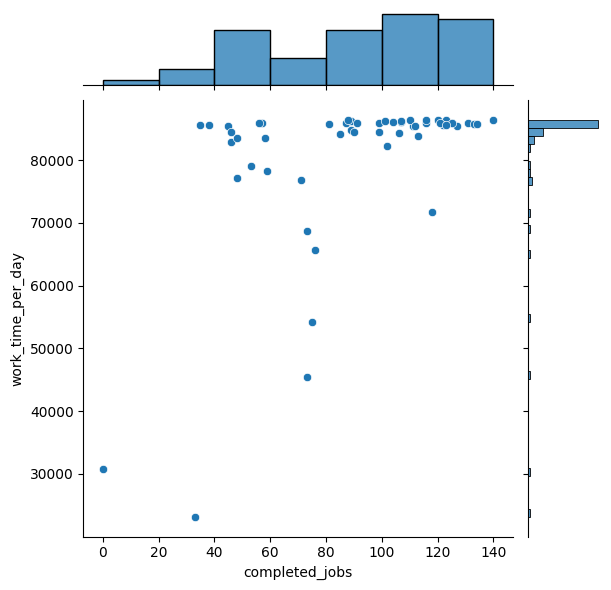

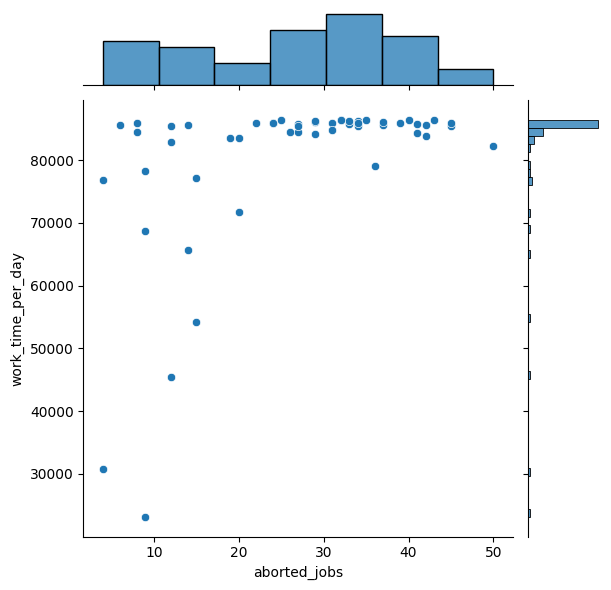

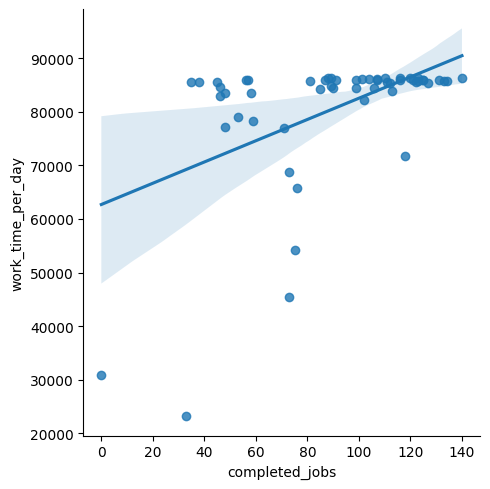

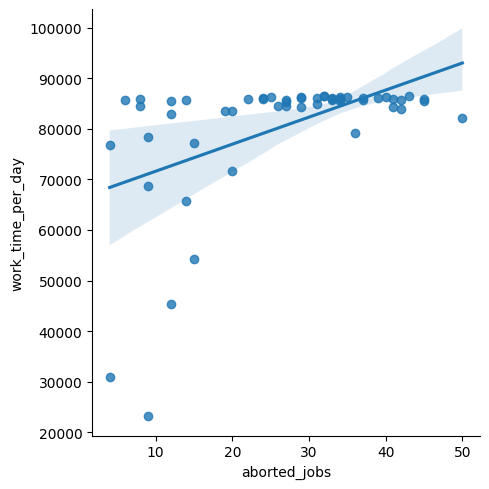

In [27]:
sns.jointplot(x='completed_jobs',y='work_time_per_day',data=mach_processed_df,kind='scatter')
sns. jointplot(x='aborted_jobs',y='work_time_per_day',data=mach_processed_df,kind='scatter')
sns.lmplot(x='completed_jobs',y='work_time_per_day',data=mach_processed_df)
sns.lmplot(x='aborted_jobs',y='work_time_per_day',data=mach_processed_df)

### Correlation per sides

Completed jobs correlation with the tyre per day by side

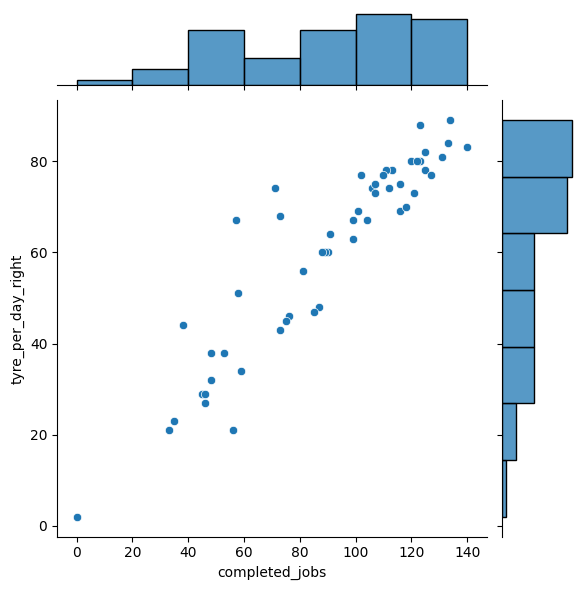

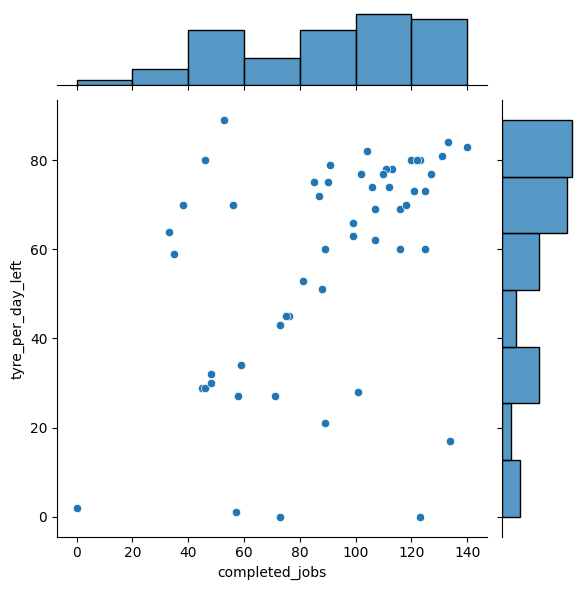

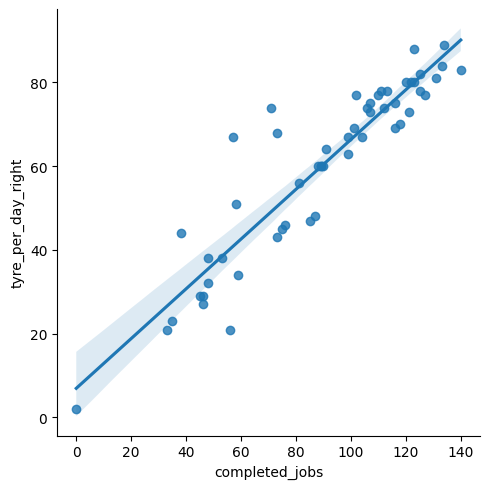

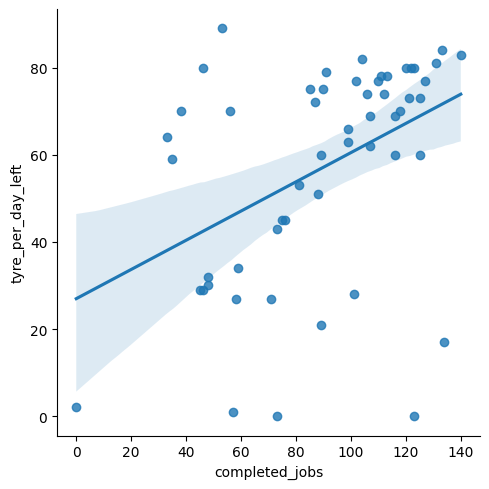

In [28]:
sns.jointplot(x='completed_jobs',y='tyre_per_day_right',data=mach_processed_df,kind='scatter')
sns.jointplot(x='completed_jobs',y='tyre_per_day_left',data=mach_processed_df,kind='scatter')
sns.lmplot(x='completed_jobs',y='tyre_per_day_right',data=mach_processed_df)
sns.lmplot(x='completed_jobs',y='tyre_per_day_left',data=mach_processed_df)

Aborted jobs correlation with the tyre per day by side

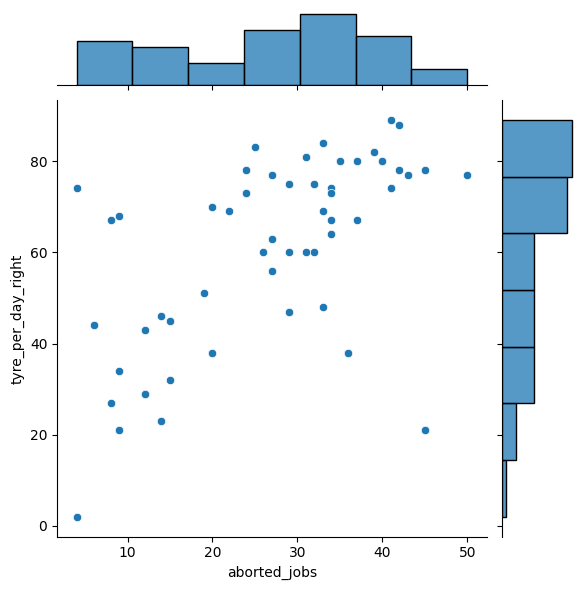

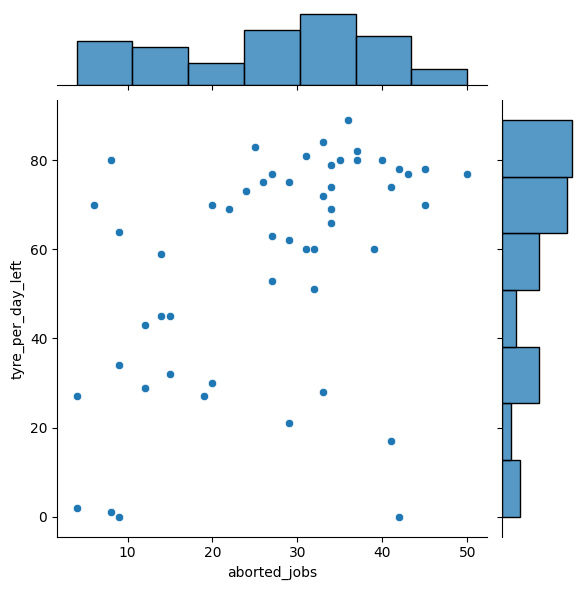

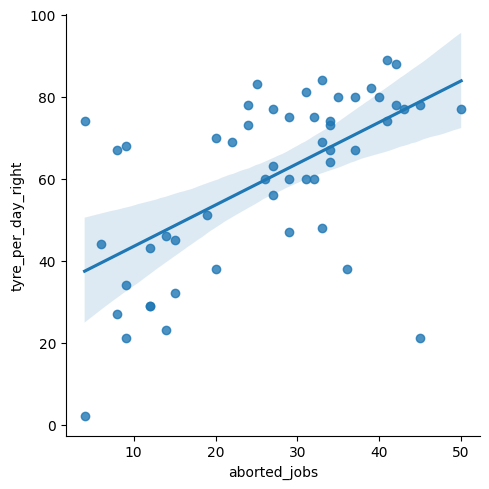

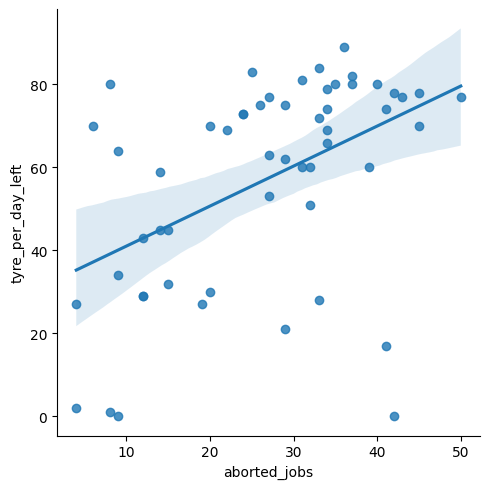

In [29]:
sns.jointplot(x='aborted_jobs',y='tyre_per_day_right',data=mach_processed_df,kind='scatter')
sns.jointplot(x='aborted_jobs',y='tyre_per_day_left',data=mach_processed_df,kind='scatter')
sns.lmplot(x='aborted_jobs',y='tyre_per_day_right',data=mach_processed_df)
sns.lmplot(x='aborted_jobs',y='tyre_per_day_left',data=mach_processed_df)

Jobs correlation with the tyre per day by side


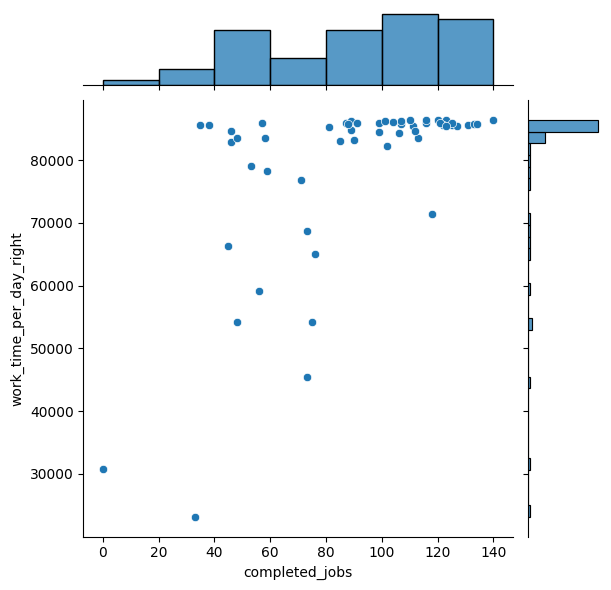

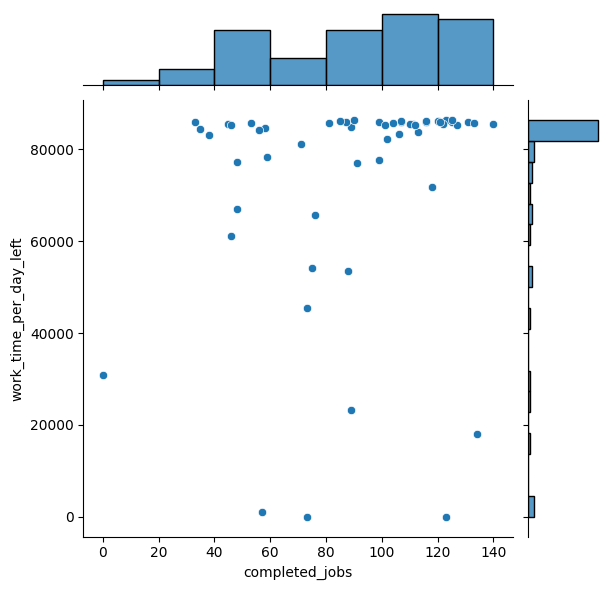

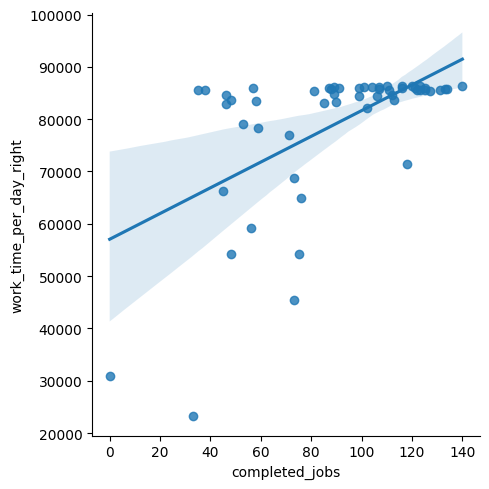

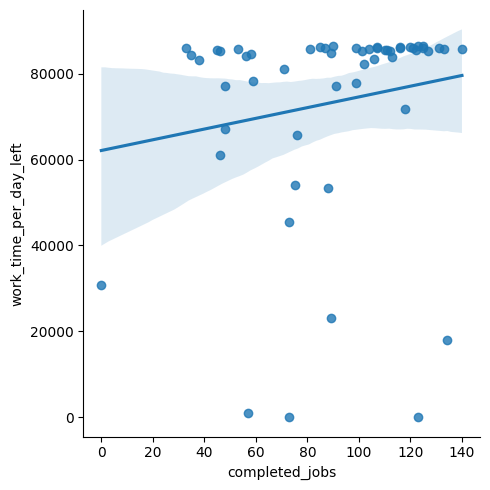

In [30]:
sns.jointplot(x='completed_jobs',y='work_time_per_day_right',data=mach_processed_df,kind='scatter')
sns.jointplot(x='completed_jobs',y='work_time_per_day_left',data=mach_processed_df,kind='scatter')
sns.lmplot(x='completed_jobs',y='work_time_per_day_right',data=mach_processed_df)
sns.lmplot(x='completed_jobs',y='work_time_per_day_left',data=mach_processed_df)

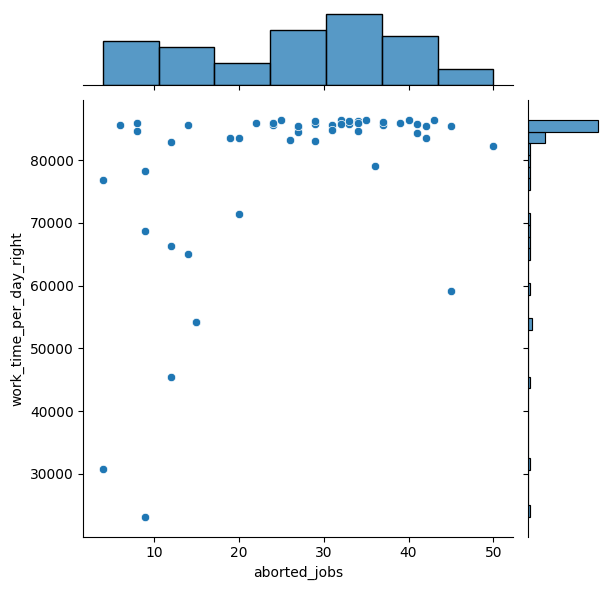

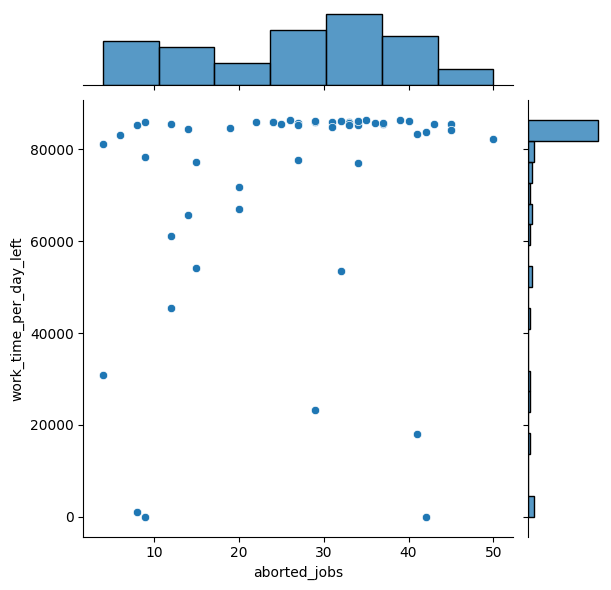

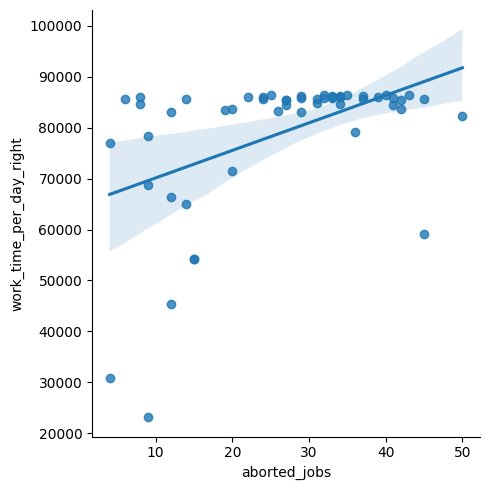

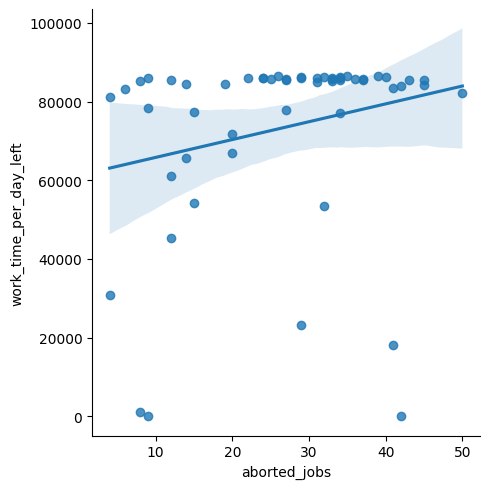

In [31]:
sns.jointplot(x='aborted_jobs',y='work_time_per_day_right',data=mach_processed_df,kind='scatter')
sns.jointplot(x='aborted_jobs',y='work_time_per_day_left',data=mach_processed_df,kind='scatter')
sns.lmplot(x='aborted_jobs',y='work_time_per_day_right',data=mach_processed_df)
sns.lmplot(x='aborted_jobs',y='work_time_per_day_left',data=mach_processed_df)

#### Ideally it should be better to check by arm instead of the enitire miachine at the moment, and apply a regression method to understand the correlation between the barcode processed and the completed cycles

#### fist check the right side

In [32]:
# the data that are more correlated are the tyre per day and the completed jobs.
print(mach_processed_df.columns)

check_corr = mach_processed_df.drop(['day'], axis=1).corr()
check_corr

Index(['day', 'tyre_per_day', 'tyre_per_day_left', 'tyre_per_day_right', 'work_time_per_day', 'work_time_per_day_left', 'work_time_per_day_right', 'completed_jobs_left', 'aborted_jobs_left', 'not_started_jobs_left', 'completed_jobs_right', 'aborted_jobs_right', 'not_started_jobs_right', 'completed_jobs', 'aborted_jobs', 'not_started_jobs'], dtype='object')


,tyre_per_day,tyre_per_day_left,tyre_per_day_right,work_time_per_day,work_time_per_day_left,work_time_per_day_right,completed_jobs_left,aborted_jobs_left,not_started_jobs_left,completed_jobs_right,aborted_jobs_right,not_started_jobs_right,completed_jobs,aborted_jobs,not_started_jobs
tyre_per_day,1.000000,0.468639,0.894841,0.527795,0.191774,0.584904,0.431432,0.421975,0.149147,0.893785,0.170783,0.021543,0.975975,0.816292,0.284255
tyre_per_day_left,0.468639,1.000000,0.261050,0.285010,0.783085,0.306594,0.932904,0.882142,0.349116,0.270120,0.042382,-0.265486,0.433007,0.472314,-0.154413
tyre_per_day_right,0.894841,0.261050,1.000000,0.510807,0.019009,0.628609,0.228688,0.255387,0.013000,0.993632,0.187564,0.198580,0.922668,0.593930,0.326266
work_time_per_day,0.527795,0.285010,0.510807,1.000000,0.260204,0.924327,0.251392,0.272668,0.067256,0.484962,0.331942,0.045658,0.488154,0.498839,0.185469
work_time_per_day_left,0.191774,0.783085,0.019009,0.260204,1.000000,0.209038,0.725395,0.690827,0.363377,0.043623,-0.108974,-0.410550,0.168736,0.232387,-0.252956
work_time_per_day_right,0.584904,0.306594,0.628609,0.924327,0.209038,1.000000,0.268039,0.305048,-0.044103,0.608771,0.285023,0.080462,0.570494,0.474823,0.206648
completed_jobs_left,0.431432,0.932904,0.228688,0.251392,0.725395,0.268039,1.000000,0.655189,0.312466,0.234452,0.078877,-0.299701,0.447452,0.308353,-0.168914
aborted_jobs_left,0.421975,0.882142,0.255387,0.272668,0.690827,0.305048,0.655189,1.000000,0.260164,0.268163,-0.019243,-0.185259,0.329656,0.584529,-0.142402
not_started_jobs_left,0.149147,0.349116,0.013000,0.067256,0.363377,-0.044103,0.312466,0.260164,1.000000,-0.000952,0.088329,0.160679,0.093377,0.221919,0.466561
completed_jobs_right,0.893785,0.270120,0.993632,0.484962,0.043623,0.608771,0.234452,0.268163,-0.000952,1.000000,0.079740,0.143767,0.929054,0.575904,0.298801


In [33]:
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

def svr_regression(x,y):
    print("Model: SVR")
    model = SVR(C=1.0, epsilon=0.2).fit(x, y)
    return model
    
def lin_regr(x, y):
    print("Model: Linear Regression")
    model = LinearRegression().fit(x, y)
    return model 

def grad_boost(x, y):
    print("Model: Gradient Boosting")
    model = GradientBoostingRegressor(random_state=0).fit(x, y)
    return model

def evaluations(x,y, f, desc = None):
    
    if desc is not None:
        print(desc)
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    
    scaler = preprocessing.RobustScaler()
    X_train = scaler.fit_transform(X_train.values.reshape(-1,1))
    y_train = scaler.fit_transform(y_train.values.reshape(-1,1))
    X_test = scaler.fit_transform(X_test.values.reshape(-1,1))
    y_test = scaler.fit_transform(y_test.values.reshape(-1,1))
    
    model = f(X_train, y_train)
    train_score = model.score(X_train, y_train)
    print(f"Model score: {train_score}")
    model_prediction = model.predict(X_test)
    accuracy_score = model.score(X_test, y_test)
    mse = mean_squared_error(y_test, model_prediction)
    r2 = r2_score(y_test, model_prediction)
    print("Metrics are:\n Accuracy: {}\n MSE: {} \n R2: {}\n\n".format(accuracy_score, mse, r2))
    
    return model

In [34]:
#split data into train and test
from sklearn.model_selection import train_test_split


right_x = mach_processed_df['tyre_per_day_right']
right_y = mach_processed_df['completed_jobs_right']



left_x = mach_processed_df['tyre_per_day_left']
left_y = mach_processed_df['completed_jobs_left']



model = evaluations(right_x, right_y, lin_regr)
model = evaluations(right_x, right_y, svr_regression)
model = evaluations(right_x, right_y, grad_boost)

model = evaluations(left_x, left_y, lin_regr)
model = evaluations(left_x, left_y, svr_regression)
model = evaluations(left_x, left_y, grad_boost)



Model: Linear Regression
Model score: 0.9893902186338183
Metrics are:
 Accuracy: 0.9674810393821065
 MSE: 0.014931888747106485 
 R2: 0.9674810393821065


Model: SVR
Model score: 0.9760202624347966
Metrics are:
 Accuracy: 0.9305286895067313
 MSE: 0.03189947832558915 
 R2: 0.9305286895067313


Model: Gradient Boosting
Model score: 0.9967915985973127
Metrics are:
 Accuracy: 0.9641159282399745
 MSE: 0.016477063138944675 
 R2: 0.9641159282399745


Model: Linear Regression
Model score: 0.8695394403359631
Metrics are:
 Accuracy: 0.30631704182898
 MSE: 1.0152788145594316 
 R2: 0.30631704182898


Model: SVR
Model score: 0.8529401394579819
Metrics are:
 Accuracy: 0.160585213593463
 MSE: 1.2285728505043896 
 R2: 0.160585213593463


Model: Gradient Boosting
Model score: 0.9645556574551523
Metrics are:
 Accuracy: 0.6069938736411691
 MSE: 0.5752062803102858 
 R2: 0.6069938736411691




### On entire machine


In [35]:
tot_x = mach_processed_df['tyre_per_day']
tot_y = mach_processed_df['completed_jobs']

model = evaluations(tot_x, tot_y, lin_regr)
model = evaluations(tot_x, tot_y, svr_regression)
model = evaluations(tot_x, tot_y, grad_boost)

Model: Linear Regression
Model score: 0.9539862231493973
Metrics are:
 Accuracy: 0.641679615845882
 MSE: 0.11060033165386038 
 R2: 0.641679615845882


Model: SVR
Model score: 0.9353452335593861
Metrics are:
 Accuracy: 0.7338065010705109
 MSE: 0.08216414853205796 
 R2: 0.7338065010705109


Model: Gradient Boosting


Model score: 0.9893955891321059
Metrics are:
 Accuracy: 0.6053554058499221
 MSE: 0.12181228009520183 
 R2: 0.6053554058499221




### evaluate the correlation between the aborted jobs and the tyre produced

In [36]:
tot_x = mach_processed_df['tyre_per_day']
tot_y = mach_processed_df['aborted_jobs']

model = evaluations(tot_x, tot_y, lin_regr)
model = evaluations(tot_x, tot_y, svr_regression)
model = evaluations(tot_x, tot_y, grad_boost)

Model: Linear Regression
Model score: 0.6733814083581825
Metrics are:
 Accuracy: 0.43807514330066033
 MSE: 0.1748974846382685 
 R2: 0.43807514330066033


Model: SVR
Model score: 0.6961313890462619
Metrics are:
 Accuracy: 0.4022249777925604
 MSE: 0.18605574485131895 
 R2: 0.4022249777925604


Model: Gradient Boosting
Model score: 0.9308178540123928
Metrics are:
 Accuracy: -0.090368626058692
 MSE: 0.3393740777838315 
 R2: -0.090368626058692


